<a href="https://colab.research.google.com/github/arupkrdas2008/Education-Rice_Disease/blob/main/Rice_Leaf_Disease_Detection_B4_Original.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Latest 02/16/2022

In [2]:
gpu_flag = False # Used when running in local PC with GPU

google_colab_flag = True # Only when used in Google Colab

lambda_flag = False  #Used when running on Lambada Labs

is_local = False


In [3]:
if(google_colab_flag or lambda_flag):
    !pip install -U --pre efficientnet
    !pip install Augmentor

     |████████████████████████████████| 50 kB 4.9 MB/s 


In [4]:
import tensorflow as tf



if(gpu_flag ):
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
      # Restrict TensorFlow to only allocate 3GB of memory on the first GPU
        try:
            tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=3900)])
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
            print(e)

## Import Library

In [5]:
import glob
import os
import random
import shutil
import time
from datetime import datetime

import pandas as pd


from tensorflow import keras



import pathlib

import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers


from sklearn.model_selection import StratifiedKFold


from tensorflow.keras.regularizers import l2
from tensorflow.keras.regularizers import l1
from tensorflow.keras.regularizers import l1_l2

import Augmentor

In [43]:
from keras.utils.layer_utils import count_params



## One time operation for file transfer

## Set Operation Path (Local vs Cloud)

In [44]:

# For training in Google Colab
if(google_colab_flag):
    from google.colab import drive
    drive.mount('/content/drive')
    !ls
    import sys
    root_path = '/content/drive/My Drive/Colab Notebooks/' # This is the path to where in google drive the code is stored!
    sys.path.append(root_path)

# For local training
else:
    #root_path = os.getcwd()
    root_path = ''

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
drive  sample_data


## Set All File Path

In [45]:
#Path of the Original Images
if(google_colab_flag):
    path = root_path + 'Original'
else:
    path = root_path + './Original'

if(google_colab_flag):
    folder_data= root_path + 'Images'
else:
    folder_data= root_path + './Images'


#MODEL_FILENAME=root_path+"model_cv.h5"
#Convert to directory type
data_dir = pathlib.Path(folder_data)
print(data_dir)

#Verify the image count to make sure we have all the pictures
image_count = len(list(data_dir.glob('**/*/*.jpeg')))
print('Total Images: ' , image_count)
print('===============================')

# Path of the train folder
TRAIN_PATH = folder_data + '/Train'
print(TRAIN_PATH)

# Path of the validation folder
VAL_PATH = folder_data + '/Validation'
print(VAL_PATH)


# Path of the test folder
TEST_PATH = folder_data + '/Test'
print(TEST_PATH)

# Defining the directory for train, validation and test images
data_dir_train = pathlib.Path(folder_data + '/Train')
data_dir_val = pathlib.Path(folder_data + '/Validation')
data_dir_test = pathlib.Path(folder_data + '/Test')

#Image count in each of the folders
image_count_train = len(list(data_dir_train.glob('*/*.jpeg')))
print(image_count_train)
image_count_val = len(list(data_dir_val.glob('*/*.jpeg')))
print(image_count_val)
image_count_test = len(list(data_dir_test.glob('*/*.jpeg')))
print(image_count_test)

TRAIN_PATH_NEW = TRAIN_PATH + "/"


/content/drive/My Drive/Colab Notebooks/Images
Total Images:  1426
/content/drive/My Drive/Colab Notebooks/Images/Train
/content/drive/My Drive/Colab Notebooks/Images/Validation
/content/drive/My Drive/Colab Notebooks/Images/Test
1162
125
139


### Set Parameters

In [46]:
#List for source file names
sourceFiles=[]

#Set the class lebels from original Dataset
classLabels= os.listdir(path)
num_classes = len(classLabels)

#For X & Y lists
X=[]
Y=[]

#Set Image size
batch_size = 64
img_height = 224
img_width = 224

#Show full text in Dataframe
#pd.set_option("display.max_colwidth", None)

In [47]:
train_datagen = ImageDataGenerator(rescale = 1/255)
validation_datagen = ImageDataGenerator(rescale = 1/255)
test_datagen  = ImageDataGenerator(rescale = 1/255)

In [48]:
def resetParameters(bath,height,width):
    batch_size = bath
    img_height = height
    img_width = width


## File move methods

In [49]:
def moveFiles(source, dest, splitRate): 
    global sourceFiles
    sourceFiles=os.listdir(source)
    if(len(sourceFiles)!=0):
        transferFileNumbers=int(len(sourceFiles)*splitRate)
        transferIndex=random.sample(range(0, len(sourceFiles)), transferFileNumbers)
        for eachIndex in transferIndex:
            shutil.move(source+str(sourceFiles[eachIndex]), dest+str(sourceFiles[eachIndex]))
    else:
        print("No file moved. Source empty!")
        
def moveAllFiles(source, dest, splitRate):
    for label in classLabels:
        moveFiles(folder_data+'/'+source+'/'+label+'/', 
                               folder_data+'/'+dest+'/'+label+'/', 
                               splitRate)

## Functions for Accuracy Check

In [50]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix
def check_Accuracy(y_true, y_pred):
    accuracy=accuracy_score(y_true, y_pred)
    precision=precision_score(y_true, y_pred,average='weighted')
    f1Score=f1_score(y_true, y_pred, average='weighted') 
    print("Accuracy  : {}".format(accuracy))
    print("Precision : {}".format(precision))
    print("f1Score : {}".format(f1Score))
    cm=confusion_matrix(y_true, y_pred)
    print(cm)
    return accuracy, precision, f1Score

## Move all files to Train

In [51]:
moveAllFiles('Test', 'Train', 1.0)
moveAllFiles('Validation', 'Train', 1.0)

if os.path.exists(folder_data + '/Temp'):
    # delete train folder
    shutil.rmtree(TRAIN_PATH)
    # Copy back from temp folder
    source = folder_data + '/Temp'
    dest =  TRAIN_PATH
    shutil.copytree(source,dest )
    shutil.rmtree(source)


### Saperate data for testing

In [52]:
#transferAllClassBetweenFolders('train', 'test', 0.10)


In [53]:
def setClassNameLabels(folderName):
    sourceFiles=os.listdir(folder_data+'/Train/'+folderName)
    for val in sourceFiles:
        X.append(val)
        for i in range(len(classLabels)):
            if(folderName==classLabels[i]):
                Y.append(i)

## Set file names for splitting

In [54]:
# Organize file names and class labels in X and Y variables
for i in range(len(classLabels)):
    setClassNameLabels(classLabels[i])

In [55]:
X=np.asarray(X)
Y=np.asarray(Y)

print(X)
print(Y)

['Hispa1_ec18d6f6-acfe-421a-afff-0c0de7820471.jpeg'
 'Hispa1_e90561cd-d030-48d2-9fc7-260acf07de10.jpeg'
 'Hispa1_a89187dd-c561-4b3b-a8d2-8cd024778bbd.jpeg' ...
 'False_Smut1_e44573f8-9249-45fd-898c-2722bff71354.jpeg'
 'False_Smut1_465e075a-10f4-483b-92f6-866de7308477.jpeg'
 'False_Smut1_3b349a07-4246-4ac4-996a-996d62de1eea.jpeg']
[0 0 0 ... 8 8 8]


# Check later on if this is required

In [56]:
trn_dataset = train_datagen.flow_from_directory(
    data_dir_train,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode = 'categorical'
)

Found 1426 images belonging to 9 classes.


In [57]:
trn_dataset.samples 

1426

In [58]:
vld_dataset = validation_datagen.flow_from_directory(
    data_dir_val,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode = 'categorical'
)

Found 0 images belonging to 9 classes.


In [59]:
tst_dataset = test_datagen.flow_from_directory(
    data_dir_test,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode = 'categorical'
)

Found 0 images belonging to 9 classes.


In [60]:
classes_nm =  list(trn_dataset.class_indices.keys())
print(classes_nm)

['BLB', 'BPH', 'Brown_Spot', 'False_Smut', 'Healthy_Plant', 'Hispa', 'Neck_Blast', 'Sheath_Blight_Rot', 'Stemborer']


In [61]:
CLASS_NAMES =  list(trn_dataset.class_indices.keys())
print(CLASS_NAMES)

['BLB', 'BPH', 'Brown_Spot', 'False_Smut', 'Healthy_Plant', 'Hispa', 'Neck_Blast', 'Sheath_Blight_Rot', 'Stemborer']


In [62]:
print(list(trn_dataset.class_indices.values()))

[0, 1, 2, 3, 4, 5, 6, 7, 8]


In [63]:
num_classes = len(trn_dataset.class_indices)
print(num_classes)

9


In [64]:
# Creating an empty Dataframe to store results
df_report = pd.DataFrame(columns=[
    'Model_Name',
    'Test_No',
    'Batch_Size', 
    'Epoch', 
    'Count',
    'Train_Average',
    'Val_Average',
    'Val_Maximum',
    'Val_Minimum',
    'Val_StandardDev',
    'Is_TL',
    'Is_SVM',
    'Is_TL_Tune',
    'Train_History',
    'Val_History',
    'Train_Summary', 
    'Val_Summary', 
    'Total_params',
    'Trainable_params',
    'Non_trainable_params',
    'Total_Records',
    'Execution_Time',
    'Precision', 
    'f1Score',
    'No_Fold',
    'Date_Time'
    ], dtype=object)
                                  

## Image Agumentation funstion

In [65]:
def count_images(imgPath):
    data_dir = pathlib.Path(imgPath)
    #print(data_dir)

    #Verify the image count to make sure we have all the pictures
    image_count = len(list(data_dir.glob('**/*.jpeg')))
    #print('Total Images: ' , image_count)
    #print('===============================')
    
    return image_count

In [66]:
def img_augmentor(path_to_training_dataset_new,CLASS_NAMES, factor):
    
    for i in CLASS_NAMES:
        temp_path = path_to_training_dataset_new + i
        req_img = count_images(temp_path) * factor
        print('\n',req_img)
        p = Augmentor.Pipeline(temp_path)
        p.rotate(probability=1, max_left_rotation=15, max_right_rotation=15)
        p.flip_left_right(probability=0.5)
        p.flip_top_bottom(probability=0.5)
        p.rotate90(probability=0.5)
        p.rotate270(probability=0.5)
        p.zoom_random(probability=0.5, percentage_area=0.8)
        p.skew(0.4, 0.5) 
        p.random_contrast(probability=0.5,min_factor = 0.2, max_factor = 0.8)
        p.random_distortion(probability=1, grid_width=4, grid_height=4, magnitude=8)
        p.flip_left_right(probability=0.5)
        
        p.sample(req_img) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

In [67]:
def move_new_images(path_to_training_dataset_new , CLASS_NAMES):
    
    for i in CLASS_NAMES:
        original_path = path_to_training_dataset_new + i
        image_count_original = count_images(original_path)
        print('Before move - ', image_count_original)
        temp_path = original_path +'/output'
        image_count_temp = count_images(temp_path)

        file_names = os.listdir(temp_path)
        #print(files)

        #shutil.copytree(, , dirs_exist_ok=True)
        source_dir = temp_path
        target_dir = original_path

        for file_name in file_names:
            shutil.move(os.path.join(source_dir, file_name), target_dir)

        shutil.rmtree(source_dir)

        #shutil.move(source+str(sourceFiles[eachIndex]), dest+str(sourceFiles[eachIndex]))
        image_count_original = count_images(original_path)
        print('After move - ', image_count_original)


In [68]:
def delete_aug_data(path_to_training_dataset_new , CLASS_NAMES):
    
    for i in CLASS_NAMES:
        original_path = path_to_training_dataset_new + i

        temp_path = original_path +'/output'

        source_dir = temp_path
        
        if os.path.exists(source_dir):
            shutil.rmtree(source_dir)


# ======> End of Checking

# Main Model Bulding Functions

## Stratified K-Fold Cross validation

In [69]:

def runStratifiedKFold(model,conv_base, batchsize,epochsNo,nosplit, df_report , 
                       createModel, modelId ,Is_TL,Is_SVM, Is_TL_Tune , Test_No,
                       TRAIN_PATH , TRAIN_PATH_NEW, CLASS_NAMES , image_factor ):
    
    
    start_time = time.time()

    print("Started at =", datetime.now().strftime("%H:%M:%S"))
    MODEL_NM = model.layers[1].name.upper()
    print('Started Model -> ',MODEL_NM)
    
    
    print('#################################################################')
    print('\n Test run = ',Test_No)

    batch_size = batchsize
    
    if (Is_TL_Tune):
        Is_TL = True
        
        
    #Delete the temp folder and if it exists already
    if os.path.exists(folder_data + '/Temp'):
        shutil.rmtree(folder_data + '/Temp')
        
    #Delete the output folder and if it exists already
    delete_aug_data(TRAIN_PATH_NEW , CLASS_NAMES)
    

    trainAcclist = []
    valAcclist = []
    valPreclist =[]
    valFScorelist =[]

    no_split = nosplit

    skf = StratifiedKFold(n_splits = no_split,random_state=42, shuffle=True)
    skf.get_n_splits(X, Y)
    foldNum=0
    for train_index, val_index in skf.split(X, Y):
        epochs = epochsNo
        #First cut all images from validation to train (if any exists)
        moveAllFiles('Validation', 'Train', 1.0)
        foldNum+=1
        print("\n Results for fold",foldNum)
        
        #Create Checking Folders 
        CHECK_PATH = folder_data + '/Checking'
        MODEL_PATH = CHECK_PATH + '/' + MODEL_NM 
        MODEL_FOLDER_PATH = MODEL_PATH + '/'  + str(foldNum)
        print('\n Folders Created ----->')
        for dirname in classLabels:
            folder_path_test = MODEL_FOLDER_PATH + '/'+ dirname
            #print(folder_path_test)
            if not os.path.exists(MODEL_PATH):
                os.mkdir(MODEL_PATH)
            if not os.path.exists(MODEL_FOLDER_PATH):
                os.mkdir(MODEL_FOLDER_PATH)


            if os.path.exists(folder_path_test):
                shutil.rmtree(folder_path_test)
            if not os.path.exists(folder_path_test):
                os.mkdir(folder_path_test)
        #End of createing test folders
            
        X_train, X_val = X[train_index], X[val_index]
        Y_train, Y_val = Y[train_index], Y[val_index]
        # Move validation images of this fold from train folder to the validation folder
        for eachIndex in range(len(X_val)):
            classLabel=''
            for i in range(len(classLabels)):
                if(Y_val[eachIndex]==i):
                    classLabel=classLabels[i]
            #Then, copy the validation images to the validation folder
            shutil.move(folder_data+'/Train/'+classLabel+'/'+X_val[eachIndex], 
                        folder_data+'/Validation/'+classLabel+'/'+X_val[eachIndex])
            
            #print('Validation Data copied')

            
            #Create a copy of the 
            #shutil.copy2(folder_data+'/Validation/'+classLabel+'/'+X_val[eachIndex], 
            #         MODEL_FOLDER_PATH+'/'+classLabel+'/'+X_val[eachIndex])
            #print(MODEL_FOLDER_PATH+'/'+classLabel+'/')
            #print('Test Data copied')
            
            
        
        #Create a backup of the Train folder
        source = TRAIN_PATH
        dest = folder_data + '/Temp' 
        shutil.copytree(source,dest )
        
        if (image_factor>1):
            #Generate extra images
            img_augmentor(TRAIN_PATH_NEW , CLASS_NAMES, image_factor)

            #Move the new imgaes to training folders
            move_new_images(TRAIN_PATH_NEW , CLASS_NAMES)
            

        #Start ImageClassification Model
        train_generator = train_datagen.flow_from_directory(
            data_dir_train,
            target_size=(img_height, img_width),
            batch_size=batch_size,
            class_mode='categorical',
            subset='training')
        
        print('Train data length ====== ', train_generator.samples)

        validation_generator = validation_datagen.flow_from_directory(
            data_dir_val,
            target_size=(img_height, img_width),
            batch_size=batch_size,
            class_mode=None,  # only data, no labels
            shuffle=False)   
        
        print('Test data length ====== ', validation_generator.samples)

        #Create model at each iteration
        if (createModel):
            model , conv_base = getModel(modelId,False , Is_TL, Is_SVM, Is_TL_Tune)
        print('Before Fine Tuning---->')
        print(model.summary())
        
        # fit model
        history=model.fit(train_generator, 
                            epochs=epochs)
        
        if (Is_TL_Tune):            #Tune the model
            
            conv_base.trainable = True
           
         
            
            optimiser = optimizers.Adam(learning_rate=1e-5)
            model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

            print('After Fine Tuning---->')
            print(model.summary())
            
            #epochs = epochsNo//2
            history=model.fit(train_generator, 
                                epochs=epochs)

            
        
        
        
        #showAccLoss(history,epochsNo)
        
        print("***Performance on Training data***") 
        trainAcc = history.history['categorical_accuracy']
        trainAcclist.append(trainAcc[-1])
        print("Accuracy  : {}".format(trainAcc[-1]))
        print("======================================*")

        predictions = model.predict(validation_generator, verbose=1)
        yPredictions = np.argmax(predictions, axis=1)
        true_classes = validation_generator.classes
        # evaluate validation performance
        print("***Performance on Validation data***")    
        valAcc, valPrec, valFScore = check_Accuracy(true_classes, yPredictions)

        valAcclist.append(valAcc)
        valPreclist.append(valPrec)
        valFScorelist.append(valFScore)
        
        
        
        #Restore the training folder ---- 
        
        # delete train folder
        shutil.rmtree(TRAIN_PATH)
        # Copy back from temp folder
        source = folder_data + '/Temp'
        dest =  TRAIN_PATH
        shutil.copytree(source,dest )
        shutil.rmtree(source)
        
        
    
        
    
    trainAccSummary = getSummary(trainAcclist)
    print('Train Summary=====>')
    print(trainAccSummary)
    
    valAccSummary = getSummary(valAcclist)
    print('Validation Summary=====>')
    print(valAccSummary)
    
    print('End Model -> ',model.layers[1].name.upper())
    print("Started at =", datetime.now().strftime("%H:%M:%S"))
    execMinutes = (time.time() - start_time)/60
    print("--- %s minutes ---" % (execMinutes))
    
    trainable_count = count_params(model.trainable_weights)
    non_trainable_count = count_params(model.non_trainable_weights)
    
    total_images = train_generator.samples + validation_generator.samples
    
    df_report = df_report.append(
            {

                'Model_Name': model.layers[1].name.upper() , 
                'Test_No': Test_No ,
                'Batch_Size': batchsize , 
                'Epoch': epochsNo, 
                'No_Fold': nosplit, 
                'Count': valAccSummary[0],
                'Train_Summary': trainAccSummary, 
                'Val_Summary': valAccSummary, 
                'Train_History':trainAcclist,
                'Val_History':valAcclist,
                'Train_Average' : trainAccSummary[1],
                'Val_Average': valAccSummary[1],
                'Val_Maximum': valAccSummary[7],
                'Val_Minimum': valAccSummary[3],
                'Val_StandardDev': valAccSummary[2],
                'Total_params': (trainable_count+non_trainable_count),
                'Trainable_params': trainable_count,
                'Non_trainable_params': non_trainable_count,
                'Total_Records': total_images,
                'Execution_Time': execMinutes,
                'Is_TL' : Is_TL ,
                'Is_SVM' : Is_SVM,
                'Is_TL_Tune' : Is_TL_Tune,
                'Date_Time' : datetime.now()

            }
        , ignore_index=True)
    
    
    return df_report

    

In [70]:
def getSummary(Acclist):
    
    print(Acclist)
    s = pd.Series(Acclist)
    return s.describe()

    


In [71]:
from matplotlib import pyplot as plt

def showAccLoss(history,num_epochs):
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(num_epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

## EfficientNetB4- Noisy Student

In [72]:
import efficientnet.tfkeras as efn
from tensorflow.keras.applications.efficientnet import EfficientNetB4



def createModel_EfficientNetB4_NS(Is_TL):

    if (Is_TL):
      
      path_to_weights = root_path + 'noisystudent/efficientnet-b4_noisy-student_notop.h5' 

      conv_base = efn.EfficientNetB4(
      weights=path_to_weights, 
      input_shape=(img_height,img_width,3),
      include_top=False,
      drop_connect_rate=0  # the hack
      )

    else:
      conv_base=EfficientNetB4(weights= None ,include_top=False,input_shape=(img_height,img_width,3))


    print('EfficientNetB4')
    #print(conv_base.summary())
    
    return conv_base

# Model Execution

In [73]:

def getModel(modelId , printSummary , Is_TL, Is_SVM, Is_TL_Tune):
    
    if model_dict[modelId] == 'VGG16':
        conv_base =  createModel_VGG16(Is_TL)
        
    elif model_dict[modelId] == 'VGG19':
        conv_base =  createModel_VGG19(Is_TL)
        
    elif model_dict[modelId] == 'ResNet50':
        conv_base =  createModel_ResNet50(Is_TL)
        
    elif model_dict[modelId] == 'ResNet50V2':
        conv_base =  createModel_ResNet50V2(Is_TL)
        
    elif model_dict[modelId] == 'ResNet152V2':
        conv_base =  createModel_ResNet152V2(Is_TL)
        
    elif model_dict[modelId] == 'EfficientNetB1':
        conv_base =  createModel_EfficientNetB1()

        
    elif model_dict[modelId] == 'EfficientNetB7':
        conv_base =  createModel_EfficientNetB7(Is_TL)

        
    elif model_dict[modelId] == 'MobileNetV2':
        conv_base =  createModel_MobileNetV2(Is_TL)

        
    elif model_dict[modelId] == 'InceptionV3':
        conv_base =  createModel_InceptionV3(Is_TL)

        
    elif model_dict[modelId] == 'DenseNet201':
        conv_base =  createModel_DenseNet201(Is_TL)

        
    elif model_dict[modelId] == 'EfficientNetB6':
        conv_base =  createModel_EfficientNetB6(Is_TL)


        
    elif model_dict[modelId] == 'EfficientNetB4NS':
        conv_base =  createModel_EfficientNetB4_NS(Is_TL)


        
    if(gpu_flag or lambda_flag):
        model =tf.keras.models.Sequential() #Required when there is GPU memory control
    else:
        model =Sequential()    #Required when there is NO GPU memory control
    
    
    
    
    if (Is_TL): ## If Transfer Learning
        conv_base.trainable = False ## Not trainable weights
        inputs = layers.Input(shape = (img_height,img_width,3), name='inputLayer')
        x = conv_base(inputs, training = False)
    elif (Is_TL_Tune):
        conv_base.trainable = False ## Not trainable weights
        inputs = layers.Input(shape = (img_height,img_width,3), name='inputLayer')
        x = conv_base(inputs, training = False)
    else:
        conv_base.trainable = True
        inputs = layers.Input(shape = (img_height,img_width,3), name='inputLayer')
        x = conv_base(inputs, training = True)
        
    
    if model_dict[modelId] == 'VGG16':
        
        x = layers.Flatten()(x)  
        x = layers.Dense(120, activation='relu')(x)  
        x = layers.Dense(84, activation='relu')(x)  
    
    elif model_dict[modelId] == 'InceptionV3':
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Flatten()(x)  
        x = layers.Dense(120, activation='relu')(x)  
        x = layers.Dense(84, activation='relu')(x)
    
        
    elif model_dict[modelId] == 'ResNet50V2':
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Flatten()(x)  
        x = layers.Dense(120, activation='relu')(x)  
        x = layers.Dense(84, activation='relu')(x)


    elif model_dict[modelId] == 'DenseNet201':
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Flatten()(x)  
        x = layers.Dense(120, activation='relu')(x)  
        x = layers.Dense(84, activation='relu')(x)

       
    elif model_dict[modelId] == 'EfficientNetB4NS':
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Flatten()(x)  
        x = layers.Dense(120, activation='relu')(x)  
        x = layers.Dense(84, activation='relu')(x)
    
    
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    
    
    if (Is_SVM):
        outputs = layers.Dense(num_classes, activation='softmax',kernel_regularizer = l1_l2(l1=0.01,l2=0.01))(x)
    else:
        outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = keras.Model(inputs, outputs)
    
    optimiser = optimizers.Adam(learning_rate=1e-4)
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
    if (printSummary):
        print('Before Merging ---->')
        print(conv_base.summary())
        
        print('After Merging ---->')
        print(model.summary()) 
        
        print('^^^^^^^^^^^^^^^^^^^^^^^^^')
    
    
    return model , conv_base


In [74]:
gpu_flag

False

In [75]:
model_dict = {1: 'VGG16', 
              2: 'VGG19',
              3: 'ResNet50',
              4: 'ResNet50V2',
              5: 'ResNet152V2',
              6: 'InceptionV3',
              7: 'MobileNetV2',
              8: 'DenseNet201',
              11: 'EfficientNetB1',
              12: 'EfficientNetB6I',
              13: 'EfficientNetB7',
              14: 'EfficientNetB6NS',
              15: 'EfficientNetB4NS'
             }
#for d in model_dict:
#    model = getModel(d)
#    df_report = runStratifiedKFold(model,24,20,10, df_report)
# runStratifiedKFold(model, batchsize,epochsNo,nosplit, df_report )

In [76]:
#def getModel(modelId , printSummary , Is_TL, Is_SVM, Is_TL_Tune):


modelId = 15

createModel = True
Is_TL = False
Is_SVM = False
Is_TL_Tune = False
printSummary = True

if (Is_TL_Tune):
    Is_TL = True

model , conv_base = getModel(modelId,printSummary,Is_TL,Is_SVM, Is_TL_Tune)

print('Started Model -> ',model.layers[1].name.upper())

EfficientNetB4
Before Merging ---->
Model: "efficientnetb4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 224, 224, 3)  0           ['input_3[0][0]']                
                                                                                                  
 normalization_2 (Normalization  (None, 224, 224, 3)  7          ['rescaling_2[0][0]']            
 )                                                                                                
                                                 

In [77]:
!python -V


Python 3.7.12


In [78]:
# def runStratifiedKFold(model,conv_base, batchsize,epochsNo,nosplit, df_report , 
#                       createModel, modelId ,Is_TL,Is_SVM, Is_TL_Tune , Test_No,
#                       TRAIN_PATH , TRAIN_PATH_NEW, CLASS_NAMES , image_factor ):

batchsize = 24
epochsNo = 20
nosplit = 10

image_factor = 5 #If >1 only then new Augumented Images will be created

for Test_No in range(1,2):
    df_report = runStratifiedKFold(model,conv_base, batchsize,epochsNo,nosplit, df_report, 
                                   createModel, modelId , Is_TL,Is_SVM, Is_TL_Tune, Test_No ,
                                  TRAIN_PATH , TRAIN_PATH_NEW, CLASS_NAMES , image_factor )


Started at = 19:01:03
Started Model ->  EFFICIENTNETB4
#################################################################

 Test run =  1
No file moved. Source empty!
No file moved. Source empty!
No file moved. Source empty!
No file moved. Source empty!
No file moved. Source empty!
No file moved. Source empty!
No file moved. Source empty!
No file moved. Source empty!
No file moved. Source empty!

 Results for fold 1

 Folders Created ----->

 620
Initialised with 124 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Images/Train/BLB/output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F7DB0198950>: 100%|██████████| 620/620 [00:05<00:00, 115.77 Samples/s]



 320
Initialised with 64 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Images/Train/BPH/output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F7DB02327D0>: 100%|██████████| 320/320 [00:02<00:00, 117.35 Samples/s]



 500
Initialised with 100 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Images/Train/Brown_Spot/output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F7DBEC6DE50>: 100%|██████████| 500/500 [00:04<00:00, 107.73 Samples/s]



 420
Initialised with 84 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Images/Train/False_Smut/output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F7DBEC30E90>: 100%|██████████| 420/420 [00:03<00:00, 112.61 Samples/s]



 1055
Initialised with 211 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Images/Train/Healthy_Plant/output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F7DB0B1BF10>: 100%|██████████| 1055/1055 [00:09<00:00, 112.43 Samples/s]



 325
Initialised with 65 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Images/Train/Hispa/output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F7EF7345990>: 100%|██████████| 325/325 [00:02<00:00, 113.25 Samples/s]



 1285
Initialised with 257 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Images/Train/Neck_Blast/output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F7DBEA2F150>: 100%|██████████| 1285/1285 [00:11<00:00, 113.34 Samples/s]



 985
Initialised with 197 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Images/Train/Sheath_Blight_Rot/output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F7DBEC25850>: 100%|██████████| 985/985 [00:08<00:00, 112.54 Samples/s]



 905
Initialised with 181 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Images/Train/Stemborer/output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F7DB52ED690>: 100%|██████████| 905/905 [00:07<00:00, 113.20 Samples/s]


Before move -  744
After move -  744
Before move -  384
After move -  384
Before move -  600
After move -  600
Before move -  504
After move -  504
Before move -  1266
After move -  1266
Before move -  390
After move -  390
Before move -  1542
After move -  1542
Before move -  1182
After move -  1182
Before move -  1086
After move -  1086
Found 7698 images belonging to 9 classes.
Train data length ======  7698
Found 143 images belonging to 9 classes.
Test data length ======  143
EfficientNetB4
Before Fine Tuning---->
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb4 (Functional)  (None, 7, 7, 1792)       17673823  
                                                                 
 global_average_pooling2d_3   (None, 1792)             0        

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F7D8A1452D0>: 100%|██████████| 620/620 [00:05<00:00, 111.56 Samples/s]



 320
Initialised with 64 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Images/Train/BPH/output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F7D8A1325D0>: 100%|██████████| 320/320 [00:02<00:00, 112.97 Samples/s]



 500
Initialised with 100 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Images/Train/Brown_Spot/output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F7D8AA38790>: 100%|██████████| 500/500 [00:04<00:00, 114.27 Samples/s]



 420
Initialised with 84 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Images/Train/False_Smut/output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F7D8A1C89D0>: 100%|██████████| 420/420 [00:03<00:00, 112.85 Samples/s]



 1055
Initialised with 211 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Images/Train/Healthy_Plant/output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F7D8A1F0F90>: 100%|██████████| 1055/1055 [00:09<00:00, 112.90 Samples/s]



 325
Initialised with 65 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Images/Train/Hispa/output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F7D8A197E90>: 100%|██████████| 325/325 [00:02<00:00, 113.88 Samples/s]



 1285
Initialised with 257 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Images/Train/Neck_Blast/output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F7D8A15ABD0>: 100%|██████████| 1285/1285 [00:11<00:00, 110.61 Samples/s]



 985
Initialised with 197 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Images/Train/Sheath_Blight_Rot/output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F7D2A4A8810>: 100%|██████████| 985/985 [00:08<00:00, 115.37 Samples/s]



 905
Initialised with 181 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Images/Train/Stemborer/output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F7D8A106590>: 100%|██████████| 905/905 [00:07<00:00, 113.55 Samples/s]


Before move -  744
After move -  744
Before move -  384
After move -  384
Before move -  600
After move -  600
Before move -  504
After move -  504
Before move -  1266
After move -  1266
Before move -  390
After move -  390
Before move -  1542
After move -  1542
Before move -  1182
After move -  1182
Before move -  1086
After move -  1086
Found 7698 images belonging to 9 classes.
Train data length ======  7698
Found 143 images belonging to 9 classes.
Test data length ======  143
EfficientNetB4
Before Fine Tuning---->
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb4 (Functional)  (None, 7, 7, 1792)       17673823  
                                                                 
 global_average_pooling2d_4   (None, 1792)             0        

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F7CF9A19950>: 100%|██████████| 620/620 [00:05<00:00, 118.36 Samples/s]



 320
Initialised with 64 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Images/Train/BPH/output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F7CF99EF810>: 100%|██████████| 320/320 [00:02<00:00, 113.66 Samples/s]



 500
Initialised with 100 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Images/Train/Brown_Spot/output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F7CF99EF810>: 100%|██████████| 500/500 [00:04<00:00, 114.17 Samples/s]



 420
Initialised with 84 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Images/Train/False_Smut/output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F7CF99D0750>: 100%|██████████| 420/420 [00:03<00:00, 114.94 Samples/s]



 1055
Initialised with 211 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Images/Train/Healthy_Plant/output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F7CF97B0ED0>: 100%|██████████| 1055/1055 [00:09<00:00, 113.56 Samples/s]



 325
Initialised with 65 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Images/Train/Hispa/output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F7CF99ED190>: 100%|██████████| 325/325 [00:02<00:00, 112.32 Samples/s]



 1285
Initialised with 257 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Images/Train/Neck_Blast/output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F7CF9981F50>: 100%|██████████| 1285/1285 [00:11<00:00, 111.98 Samples/s]



 985
Initialised with 197 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Images/Train/Sheath_Blight_Rot/output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F7CF9812F10>: 100%|██████████| 985/985 [00:08<00:00, 113.90 Samples/s]



 905
Initialised with 181 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Images/Train/Stemborer/output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F7CF97E1650>: 100%|██████████| 905/905 [00:07<00:00, 113.64 Samples/s]


Before move -  744
After move -  744
Before move -  384
After move -  384
Before move -  600
After move -  600
Before move -  504
After move -  504
Before move -  1266
After move -  1266
Before move -  390
After move -  390
Before move -  1542
After move -  1542
Before move -  1182
After move -  1182
Before move -  1086
After move -  1086
Found 7698 images belonging to 9 classes.
Train data length ======  7698
Found 143 images belonging to 9 classes.
Test data length ======  143
EfficientNetB4
Before Fine Tuning---->
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb4 (Functional)  (None, 7, 7, 1792)       17673823  
                                                                 
 global_average_pooling2d_5   (None, 1792)             0        

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F7D8B819310>: 100%|██████████| 625/625 [00:05<00:00, 115.32 Samples/s]



 320
Initialised with 64 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Images/Train/BPH/output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F7DB00C4F90>: 100%|██████████| 320/320 [00:02<00:00, 114.05 Samples/s]



 500
Initialised with 100 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Images/Train/Brown_Spot/output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F7CF84B7D50>: 100%|██████████| 500/500 [00:05<00:00, 94.84 Samples/s] 



 415
Initialised with 83 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Images/Train/False_Smut/output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F7E60188C90>: 100%|██████████| 415/415 [00:03<00:00, 112.99 Samples/s]



 1055
Initialised with 211 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Images/Train/Healthy_Plant/output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F7D2AA80E90>: 100%|██████████| 1055/1055 [00:09<00:00, 112.84 Samples/s]



 330
Initialised with 66 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Images/Train/Hispa/output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F7DB0EB4350>: 100%|██████████| 330/330 [00:02<00:00, 115.79 Samples/s]



 1285
Initialised with 257 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Images/Train/Neck_Blast/output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F7CF8580210>: 100%|██████████| 1285/1285 [00:11<00:00, 111.85 Samples/s]



 985
Initialised with 197 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Images/Train/Sheath_Blight_Rot/output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F7D2A64BD50>: 100%|██████████| 985/985 [00:08<00:00, 112.89 Samples/s]



 900
Initialised with 180 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Images/Train/Stemborer/output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F7D8AA3DF10>: 100%|██████████| 900/900 [00:08<00:00, 111.75 Samples/s]


Before move -  750
After move -  750
Before move -  384
After move -  384
Before move -  600
After move -  600
Before move -  498
After move -  498
Before move -  1266
After move -  1266
Before move -  396
After move -  396
Before move -  1542
After move -  1542
Before move -  1182
After move -  1182
Before move -  1080
After move -  1080
Found 7698 images belonging to 9 classes.
Train data length ======  7698
Found 143 images belonging to 9 classes.
Test data length ======  143
EfficientNetB4
Before Fine Tuning---->
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb4 (Functional)  (None, 7, 7, 1792)       17673823  
                                                                 
 global_average_pooling2d_6   (None, 1792)             0        

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F799B533750>: 100%|██████████| 625/625 [00:05<00:00, 113.60 Samples/s]



 320
Initialised with 64 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Images/Train/BPH/output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F799B52A490>: 100%|██████████| 320/320 [00:02<00:00, 116.50 Samples/s]



 495
Initialised with 99 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Images/Train/Brown_Spot/output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F799B3727D0>: 100%|██████████| 495/495 [00:04<00:00, 115.25 Samples/s]



 415
Initialised with 83 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Images/Train/False_Smut/output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F799B366BD0>: 100%|██████████| 415/415 [00:03<00:00, 115.88 Samples/s]



 1055
Initialised with 211 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Images/Train/Healthy_Plant/output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F799AFA5250>: 100%|██████████| 1055/1055 [00:09<00:00, 116.02 Samples/s]



 330
Initialised with 66 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Images/Train/Hispa/output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F799B18E190>: 100%|██████████| 330/330 [00:02<00:00, 116.13 Samples/s]



 1285
Initialised with 257 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Images/Train/Neck_Blast/output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F799B426910>: 100%|██████████| 1285/1285 [00:11<00:00, 114.46 Samples/s]



 985
Initialised with 197 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Images/Train/Sheath_Blight_Rot/output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F7D2AA1A650>: 100%|██████████| 985/985 [00:09<00:00, 105.72 Samples/s]



 905
Initialised with 181 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Images/Train/Stemborer/output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F7D2B076D10>: 100%|██████████| 905/905 [00:08<00:00, 112.80 Samples/s]


Before move -  750
After move -  750
Before move -  384
After move -  384
Before move -  594
After move -  594
Before move -  498
After move -  498
Before move -  1266
After move -  1266
Before move -  396
After move -  396
Before move -  1542
After move -  1542
Before move -  1182
After move -  1182
Before move -  1086
After move -  1086
Found 7698 images belonging to 9 classes.
Train data length ======  7698
Found 143 images belonging to 9 classes.
Test data length ======  143
EfficientNetB4
Before Fine Tuning---->
Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb4 (Functional)  (None, 7, 7, 1792)       17673823  
                                                                 
 global_average_pooling2d_7   (None, 1792)             0        

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F799ABDC350>: 100%|██████████| 620/620 [00:05<00:00, 113.94 Samples/s]



 315
Initialised with 63 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Images/Train/BPH/output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F799AA32A90>: 100%|██████████| 315/315 [00:03<00:00, 99.66 Samples/s] 



 500
Initialised with 100 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Images/Train/Brown_Spot/output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F799AA24F10>: 100%|██████████| 500/500 [00:04<00:00, 114.17 Samples/s]



 415
Initialised with 83 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Images/Train/False_Smut/output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F799AB56790>: 100%|██████████| 415/415 [00:03<00:00, 119.12 Samples/s]



 1055
Initialised with 211 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Images/Train/Healthy_Plant/output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F799AC0B9D0>: 100%|██████████| 1055/1055 [00:09<00:00, 115.01 Samples/s]



 330
Initialised with 66 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Images/Train/Hispa/output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F799ABA1950>: 100%|██████████| 330/330 [00:02<00:00, 113.34 Samples/s]



 1290
Initialised with 258 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Images/Train/Neck_Blast/output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F799A5B7510>: 100%|██████████| 1290/1290 [00:11<00:00, 113.23 Samples/s]



 985
Initialised with 197 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Images/Train/Sheath_Blight_Rot/output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F799A6353D0>: 100%|██████████| 985/985 [00:08<00:00, 114.33 Samples/s]



 905
Initialised with 181 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Images/Train/Stemborer/output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F799A658410>: 100%|██████████| 905/905 [00:08<00:00, 112.72 Samples/s]


Before move -  744
After move -  744
Before move -  378
After move -  378
Before move -  600
After move -  600
Before move -  498
After move -  498
Before move -  1266
After move -  1266
Before move -  396
After move -  396
Before move -  1548
After move -  1548
Before move -  1182
After move -  1182
Before move -  1086
After move -  1086
Found 7698 images belonging to 9 classes.
Train data length ======  7698
Found 143 images belonging to 9 classes.
Test data length ======  143
EfficientNetB4
Before Fine Tuning---->
Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb4 (Functional)  (None, 7, 7, 1792)       17673823  
                                                                 
 global_average_pooling2d_8   (None, 1792)             0        

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F7DB05B3890>: 100%|██████████| 620/620 [00:05<00:00, 117.42 Samples/s]



 320
Initialised with 64 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Images/Train/BPH/output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F7D2B94F590>: 100%|██████████| 320/320 [00:02<00:00, 117.50 Samples/s]



 500
Initialised with 100 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Images/Train/Brown_Spot/output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F799B4FDAD0>: 100%|██████████| 500/500 [00:04<00:00, 116.37 Samples/s]



 420
Initialised with 84 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Images/Train/False_Smut/output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F799AC78990>: 100%|██████████| 420/420 [00:03<00:00, 118.20 Samples/s]



 1050
Initialised with 210 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Images/Train/Healthy_Plant/output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F7DB0A54DD0>: 100%|██████████| 1050/1050 [00:09<00:00, 113.13 Samples/s]



 330
Initialised with 66 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Images/Train/Hispa/output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F7D2B793990>: 100%|██████████| 330/330 [00:02<00:00, 117.08 Samples/s]



 1290
Initialised with 258 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Images/Train/Neck_Blast/output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F7E601FE690>: 100%|██████████| 1290/1290 [00:11<00:00, 117.14 Samples/s]



 985
Initialised with 197 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Images/Train/Sheath_Blight_Rot/output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F7DB066A190>: 100%|██████████| 985/985 [00:08<00:00, 118.14 Samples/s]



 905
Initialised with 181 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Images/Train/Stemborer/output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F799C3EF910>: 100%|██████████| 905/905 [00:07<00:00, 117.37 Samples/s]


Before move -  744
After move -  744
Before move -  384
After move -  384
Before move -  600
After move -  600
Before move -  504
After move -  504
Before move -  1260
After move -  1260
Before move -  396
After move -  396
Before move -  1548
After move -  1548
Before move -  1182
After move -  1182
Before move -  1086
After move -  1086
Found 7704 images belonging to 9 classes.
Train data length ======  7704
Found 142 images belonging to 9 classes.
Test data length ======  142
EfficientNetB4
Before Fine Tuning---->
Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb4 (Functional)  (None, 7, 7, 1792)       17673823  
                                                                 
 global_average_pooling2d_9   (None, 1792)             0        

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F7D8B4273D0>: 100%|██████████| 620/620 [00:05<00:00, 116.86 Samples/s]



 320
Initialised with 64 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Images/Train/BPH/output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F7D8B208ED0>: 100%|██████████| 320/320 [00:02<00:00, 116.73 Samples/s]



 500
Initialised with 100 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Images/Train/Brown_Spot/output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F7D8B430490>: 100%|██████████| 500/500 [00:04<00:00, 114.25 Samples/s]



 420
Initialised with 84 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Images/Train/False_Smut/output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F7D8B41D410>: 100%|██████████| 420/420 [00:03<00:00, 114.61 Samples/s]



 1050
Initialised with 210 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Images/Train/Healthy_Plant/output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F799C886450>: 100%|██████████| 1050/1050 [00:09<00:00, 109.26 Samples/s]



 330
Initialised with 66 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Images/Train/Hispa/output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F7CF8440D90>: 100%|██████████| 330/330 [00:02<00:00, 117.81 Samples/s]



 1290
Initialised with 258 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Images/Train/Neck_Blast/output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F7D8B41E750>: 100%|██████████| 1290/1290 [00:11<00:00, 116.03 Samples/s]



 985
Initialised with 197 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Images/Train/Sheath_Blight_Rot/output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F7DB045DE50>: 100%|██████████| 985/985 [00:08<00:00, 116.54 Samples/s]



 905
Initialised with 181 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Images/Train/Stemborer/output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F7D8B280650>: 100%|██████████| 905/905 [00:07<00:00, 115.72 Samples/s]


Before move -  744
After move -  744
Before move -  384
After move -  384
Before move -  600
After move -  600
Before move -  504
After move -  504
Before move -  1260
After move -  1260
Before move -  396
After move -  396
Before move -  1548
After move -  1548
Before move -  1182
After move -  1182
Before move -  1086
After move -  1086
Found 7704 images belonging to 9 classes.
Train data length ======  7704
Found 142 images belonging to 9 classes.
Test data length ======  142
EfficientNetB4
Before Fine Tuning---->
Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb4 (Functional)  (None, 7, 7, 1792)       17673823  
                                                                 
 global_average_pooling2d_10  (None, 1792)             0       

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F7CF8A846D0>: 100%|██████████| 620/620 [00:05<00:00, 104.59 Samples/s]



 320
Initialised with 64 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Images/Train/BPH/output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F799BE443D0>: 100%|██████████| 320/320 [00:02<00:00, 116.33 Samples/s]



 500
Initialised with 100 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Images/Train/Brown_Spot/output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F799BEDE810>: 100%|██████████| 500/500 [00:04<00:00, 119.25 Samples/s]



 420
Initialised with 84 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Images/Train/False_Smut/output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F799BEE2350>: 100%|██████████| 420/420 [00:03<00:00, 117.92 Samples/s]



 1050
Initialised with 210 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Images/Train/Healthy_Plant/output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F799BD19DD0>: 100%|██████████| 1050/1050 [00:08<00:00, 119.70 Samples/s]



 330
Initialised with 66 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Images/Train/Hispa/output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F7CF8ABCA10>: 100%|██████████| 330/330 [00:02<00:00, 117.75 Samples/s]



 1290
Initialised with 258 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Images/Train/Neck_Blast/output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F799BE1C710>: 100%|██████████| 1290/1290 [00:11<00:00, 116.71 Samples/s]



 985
Initialised with 197 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Images/Train/Sheath_Blight_Rot/output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F799BDBFA50>: 100%|██████████| 985/985 [00:08<00:00, 119.33 Samples/s]



 905
Initialised with 181 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Images/Train/Stemborer/output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F799BE9B9D0>: 100%|██████████| 905/905 [00:07<00:00, 118.90 Samples/s]


Before move -  744
After move -  744
Before move -  384
After move -  384
Before move -  600
After move -  600
Before move -  504
After move -  504
Before move -  1260
After move -  1260
Before move -  396
After move -  396
Before move -  1548
After move -  1548
Before move -  1182
After move -  1182
Before move -  1086
After move -  1086
Found 7704 images belonging to 9 classes.
Train data length ======  7704
Found 142 images belonging to 9 classes.
Test data length ======  142
EfficientNetB4
Before Fine Tuning---->
Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb4 (Functional)  (None, 7, 7, 1792)       17673823  
                                                                 
 global_average_pooling2d_11  (None, 1792)             0       

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F799BAE2750>: 100%|██████████| 620/620 [00:05<00:00, 120.03 Samples/s]



 320
Initialised with 64 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Images/Train/BPH/output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F799BB52890>: 100%|██████████| 320/320 [00:02<00:00, 123.02 Samples/s]



 500
Initialised with 100 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Images/Train/Brown_Spot/output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F799B9F1850>: 100%|██████████| 500/500 [00:04<00:00, 119.91 Samples/s]



 420
Initialised with 84 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Images/Train/False_Smut/output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F799BA07350>: 100%|██████████| 420/420 [00:03<00:00, 120.77 Samples/s]



 1050
Initialised with 210 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Images/Train/Healthy_Plant/output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F799B9B0A50>: 100%|██████████| 1050/1050 [00:10<00:00, 102.94 Samples/s]



 330
Initialised with 66 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Images/Train/Hispa/output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F799BA03A50>: 100%|██████████| 330/330 [00:02<00:00, 118.96 Samples/s]



 1285
Initialised with 257 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Images/Train/Neck_Blast/output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F799A4AA3D0>: 100%|██████████| 1285/1285 [00:10<00:00, 120.04 Samples/s]



 990
Initialised with 198 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Images/Train/Sheath_Blight_Rot/output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F799BB78B90>: 100%|██████████| 990/990 [00:08<00:00, 119.49 Samples/s]



 905
Initialised with 181 image(s) found.
Output directory set to /content/drive/My Drive/Colab Notebooks/Images/Train/Stemborer/output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F799BACF210>: 100%|██████████| 905/905 [00:07<00:00, 120.32 Samples/s]


Before move -  744
After move -  744
Before move -  384
After move -  384
Before move -  600
After move -  600
Before move -  504
After move -  504
Before move -  1260
After move -  1260
Before move -  396
After move -  396
Before move -  1542
After move -  1542
Before move -  1188
After move -  1188
Before move -  1086
After move -  1086
Found 7704 images belonging to 9 classes.
Train data length ======  7704
Found 142 images belonging to 9 classes.
Test data length ======  142
EfficientNetB4
Before Fine Tuning---->
Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb4 (Functional)  (None, 7, 7, 1792)       17673823  
                                                                 
 global_average_pooling2d_12  (None, 1792)             0       

### Run Model

In [79]:
df_report

,Model_Name,Test_No,Batch_Size,Epoch,Count,Train_Average,Val_Average,Val_Maximum,Val_Minimum,Val_StandardDev,Is_TL,Is_SVM,Is_TL_Tune,Train_History,Val_History,Train_Summary,Val_Summary,Total_params,Trainable_params,Non_trainable_params,Total_Records,Execution_Time,Precision,f1Score,No_Fold,Date_Time
0,EFFICIENTNETB4,1,24,20,10.0,0.804402,0.358283,0.440559,0.288732,0.047557,False,False,False,"[0.7753962278366089, 0.8209924697875977, 0.817...","[0.3706293706293706, 0.3986013986013986, 0.356...",count 10.000000 mean 0.804402 std ...,count 10.000000 mean 0.358283 std ...,17899912,17774705,125207,7846,301.364507,NaN,NaN,10,2022-02-17 00:02:25.579924


In [80]:
from IPython.display import display, HTML
display(HTML(df_report.to_html()))

,Model_Name,Test_No,Batch_Size,Epoch,Count,Train_Average,Val_Average,Val_Maximum,Val_Minimum,Val_StandardDev,Is_TL,Is_SVM,Is_TL_Tune,Train_History,Val_History,Train_Summary,Val_Summary,Total_params,Trainable_params,Non_trainable_params,Total_Records,Execution_Time,Precision,f1Score,No_Fold,Date_Time
0,EFFICIENTNETB4,1,24,20,10.0,0.804402,0.358283,0.440559,0.288732,0.047557,False,False,False,"[0.7753962278366089, 0.8209924697875977, 0.8176149725914001, 0.8133281469345093, 0.8268381357192993, 0.7948817610740662, 0.8037382960319519, 0.804646909236908, 0.7945223450660706, 0.7920560836791992]","[0.3706293706293706, 0.3986013986013986, 0.35664335664335667, 0.4405594405594406, 0.36363636363636365, 0.3076923076923077, 0.2887323943661972, 0.4014084507042254, 0.34507042253521125, 0.30985915492957744]",count 10.000000 mean 0.804402 std 0.015689 min 0.775396 25% 0.794612 50% 0.804193 75% 0.816543 max 0.826838 dtype: float64,count 10.000000 mean 0.358283 std 0.047557 min 0.288732 25% 0.318662 50% 0.360140 75% 0.391608 max 0.440559 dtype: float64,17899912,17774705,125207,7846,301.364507,NaN,NaN,10,2022-02-17 00:02:25.579924


In [81]:
print('Started Model -> ',model.layers[0].name.upper())

Started Model ->  INPUTLAYER


In [82]:
print('Started Model -> ',model.layers[1].name.upper())

Started Model ->  EFFICIENTNETB4


In [83]:
root_path

'/content/drive/My Drive/Colab Notebooks/'

(1, 7, 7, 1792)


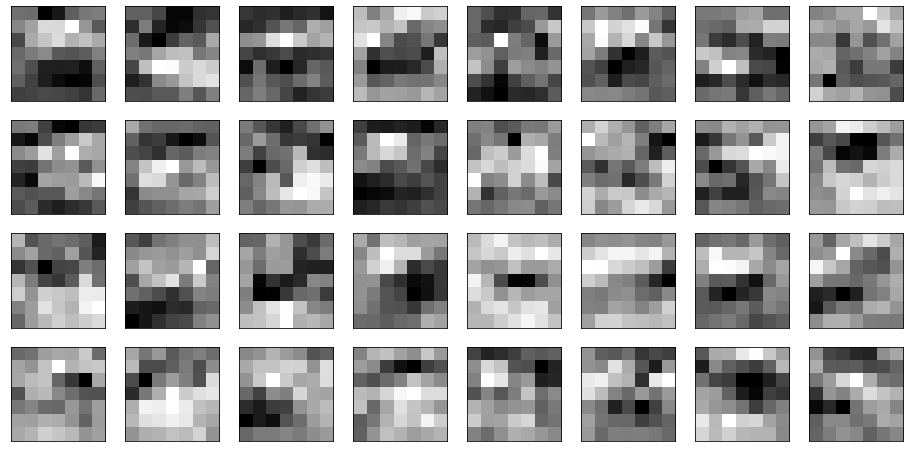

In [84]:
from matplotlib import pyplot
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import preprocess_input


from tensorflow.keras.preprocessing import image
import numpy as np
#from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
import pylab
#model = VGG16(weights='imagenet', include_top=False)
#model = MobileNetV2(weights='imagenet', include_top=False)

if (is_local):
    img_path = './R_D_Images/BLB1.jpeg'
else:
    img_path = root_path + '/R_D_Images/BLB1.jpeg'
    

img = image.load_img(img_path)
Y = image.img_to_array(img)
Y = np.expand_dims(Y, axis=0)
Y = preprocess_input(Y)

features = conv_base.predict(Y)

print(features.shape)


row = 4
col = row * 2
ix = 1
pyplot.figure(figsize=(col * 2, row * 2))



for _ in range(row):
    for _ in range(col):
        # specify subplot and turn of axis
        ax = pyplot.subplot(row, col, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        pyplot.imshow(features[0, :, :, ix-1], cmap='gray')
        ix += 1
# show the figure
pyplot.show()



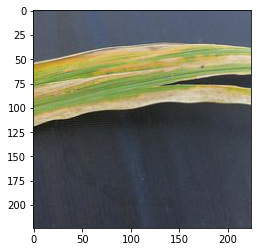

In [85]:

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

imgplot = plt.imshow(img)
plt.show()

(1, 7, 7, 1792)


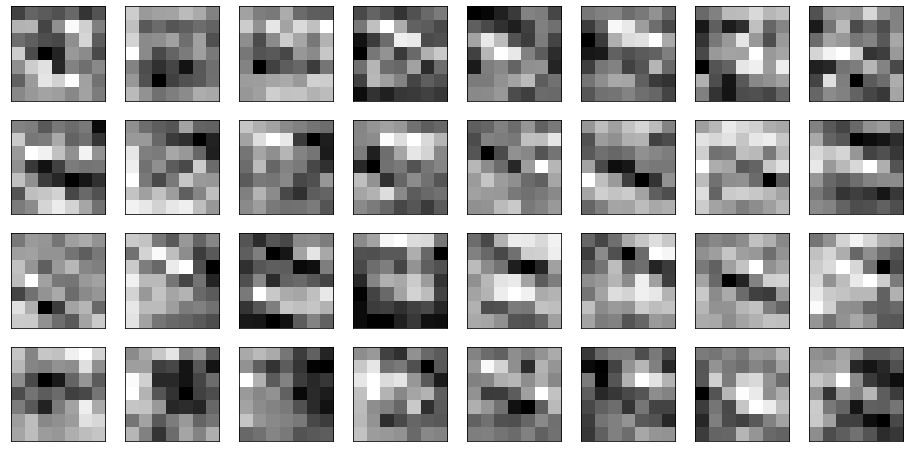

In [86]:
from matplotlib import pyplot
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import preprocess_input


from tensorflow.keras.preprocessing import image
import numpy as np
#from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
import pylab
#model = VGG16(weights='imagenet', include_top=False)
#model = MobileNetV2(weights='imagenet', include_top=False)


if (is_local):
    img_path = './R_D_Images/BLB2.jpeg'
else:
    img_path = root_path + '/R_D_Images/BLB2.jpeg'
    
    
img = image.load_img(img_path)
Y = image.img_to_array(img)
Y = np.expand_dims(Y, axis=0)
Y = preprocess_input(Y)

features = conv_base.predict(Y)

print(features.shape)


row = 4
col = row * 2
ix = 1
pyplot.figure(figsize=(col * 2, row * 2))



for _ in range(row):
    for _ in range(col):
        # specify subplot and turn of axis
        ax = pyplot.subplot(row, col, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        pyplot.imshow(features[0, :, :, ix-1], cmap='gray')
        ix += 1
# show the figure
pyplot.show()



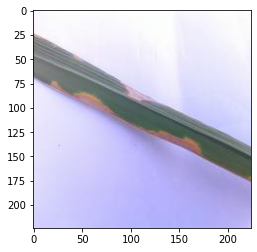

In [87]:

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

imgplot = plt.imshow(img)
plt.show()